For the final project, I'll analyze the CoffeeKing dataset (Yelp Academic Dataset), to see if there's anything interesting we can dig out.  
Here's the discription:  
CoffeeKing is a new startup coffee company providing a unique and novel experience to their customers.  They want to appeal to a wide variety of clientele.  You will use Yelp reviews and user data to provide insights to CoffeeKing for things such as location selection and/or hours of operation (and other questions?)  
  
### First, import the packages we needed to do EDA.

In [1]:
import pandas as pd
import numpy as np
from pandasql import sqldf
# import importlib
# importlib.reload(util)
from util import *

In [60]:
import matplotlib
import matplotlib.pyplot as plt
import scipy
import ast
pd.set_option('display.max_colwidth',-1)

C:\Users\user\AppData\Local\Temp/ipykernel_15184/1767223208.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1)


Check for data's basic information.

In [102]:
# Check for total size
json_path = 'C:/Users/user/Desktop/CoffeKing (Yelp Academic Dataset)/'

print('size of store: ', count_total_rows(json_path, 'yelp_academic_dataset_business.json', 100000))
print('size of review: ', count_total_rows(json_path, 'yelp_academic_dataset_review.json', 100000))
print('size of user: ', count_total_rows(json_path, 'yelp_academic_dataset_user.json', 100000))

size of store:  160585
size of review:  8635403
size of user:  2189457


In [152]:
# Find stores selling coffee
yelp_bs = pd.read_json(json_path + 'yelp_academic_dataset_business.json', lines=True)
yelp_bs['categories'] = yelp_bs['categories'].map(lambda x: to_lower_case(x))
yelp_bs = yelp_bs[yelp_bs['categories'].str.contains('coffee').map(lambda x: True if x is True else False)] # Find store category with "coffee"
coffee_id = list(yelp_bs['business_id'])

In [154]:
# Deal with review, append reviews of the coffee stores
coffee_review = []
with open(json_path + "yelp_academic_dataset_review.json", "r") as f:
    reader = pd.read_json(json_path + "yelp_academic_dataset_review.json", 
                        lines=True, chunksize=100000)
    for chunk in reader:
        chunk = chunk[chunk['business_id'].isin(coffee_id)]
        coffee_review.append(chunk)
f.close()

In [155]:
yelp_rv = pd.concat(coffee_review, ignore_index=True)
user_id = yelp_rv['user_id'].unique().tolist()

In [156]:
# Search for user information
user_info = []
with open(json_path + "yelp_academic_dataset_user.json", "r") as f:
    reader = pd.read_json(json_path + "yelp_academic_dataset_user.json", 
                        lines=True, chunksize=100000)
    for chunk in reader:
        chunk = chunk[chunk['user_id'].isin(user_id)]
        user_info.append(chunk)
f.close()

In [157]:
yelp_user = pd.concat(user_info, ignore_index=True)

In [158]:
# Drop columns we don't need
yelp_bs.drop(["address", "postal_code", "latitude", "longitude"], axis=1, inplace=True)
yelp_rv.drop(["review_id"], axis=1, inplace=True)
yelp_user.drop(["name", "friends"], axis=1, inplace=True)

In [159]:
# Change column names that may duplicated
yelp_bs.rename(columns={"stars":"store_stars", "review_count":"store_review_count"}, inplace=True)
yelp_rv.rename(columns={"stars":"rv_stars", "useful":"rv_useful", "funny":"rv_funny", "cool":"rv_cool"}, inplace=True)
yelp_user.rename(columns={"review_count":"user_review_count"}, inplace=True)

In [160]:
# Merge tables, base on review
yelp_coffee = pd.merge(pd.merge(yelp_rv, yelp_bs, on="business_id", how='left'), 
                        yelp_user, on="user_id", how='left')

In [162]:
# Save merged table
yelp_coffee.to_csv(json_path + 'yelp_coffee.csv')

In [161]:
# Brief descrive of our merged table
print('We have {} distinct coffee stores.'.format(yelp_coffee['business_id'].unique().shape[0]))
print('With {} reviews about those stores.'.format(yelp_coffee.shape[0]))
print('And {} distinct users comment on them.'.format(yelp_coffee['user_id'].unique().shape[0]))
print('Our merged table has {} rows and {} features.'.format(yelp_coffee.shape[0],yelp_coffee.shape[1]))

We have 7747 distinct coffee stores.
With 605303 reviews about those stores.
And 321890 distinct users comment on them.
Our merged table has 605303 rows and 36 features.


### Now we can start to find what's in our table.

In [14]:
json_path = 'C:/Users/user/Desktop/CoffeKing (Yelp Academic Dataset)/'
yelp_coffee = pd.read_csv(json_path + 'yelp_coffee_category.csv',index_col=0)
yelp_coffee

,user_id,business_id,rv_stars,rv_useful,rv_funny,rv_cool,text,date,name,city,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JHXQEayrDHOWGexs0dCviA,KXCXaF5qimmtKKqnPc_LQA,1,0,0,0,Great coffee and pastries. Baristas are excell...,2018-03-03 23:45:25,Thierry,Vancouver,...,2,0,0,0,2,11,2,2,0,1
1,LV1ME-ibA2h0IGyFUUWhaQ,H_RM2u1WWGU1HkKZrYq2Ow,5,0,0,0,Incredible donuts. Sometimes you have to go ea...,2017-08-07 19:34:13,Blue Star Donuts,Portland,...,0,0,0,0,0,1,0,0,0,0
2,JuM-lH05m6Ln8OPUTg8p0g,H_RM2u1WWGU1HkKZrYq2Ow,5,0,0,0,"Dont bother going to voodoo, just come here in...",2016-09-18 17:06:01,Blue Star Donuts,Portland,...,0,0,0,0,0,1,0,0,0,0
3,4cDqW9sWnZ57tsIEiElJWw,0nMbLN0B5I-2tNnQLSo86w,5,4,4,4,"""Even the mad Captain Ahab is touched by Starb...",2017-12-02 19:41:59,Starbucks,Portland,...,16,0,3,0,82,224,237,237,66,75
4,7mWnNVk2n99JxkvV3PW0nA,Un6u2cECyV4nZb_HGZ-uTA,4,1,0,1,It's crazy how establishments on the west coas...,2011-02-13 16:38:09,Tin Shed Garden Cafe,Portland,...,4,1,0,3,12,28,28,28,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605298,im-MIiI-UFJsdrmIaxer2A,edlA6hSakvNxRZQFbuf-Iw,3,0,0,0,I've always gone to sharetea wherever I go for...,2021-01-25 23:04:35,Sharetea,Beaverton,...,0,0,0,0,0,0,0,0,0,0
605299,Cs5isLcwZgK-Cd1SA4TShw,p4sp8NYrFW7MmBajumBrtg,1,1,0,0,Every time I come to this dunkin they don't gi...,2020-06-30 14:21:53,Dunkin',Dunwoody,...,0,0,0,0,0,0,0,0,0,0
605300,_ailSgaI-3ztQxRnZtcluw,3uyvi_du7-sMxkYpcAg0-A,5,0,0,0,This place is poppin'! Very much enjoyed their...,2020-12-13 17:33:09,"Greystone Cafe, Bakery, and Provisions",Boston,...,0,0,0,0,0,0,0,0,1,0
605301,VEB7udH-qIN_ON1SMyWrPg,zM98ZSIJyuBQabyYornLpw,3,0,0,0,Bartender was friendly and attentive. We came ...,2021-01-10 04:10:45,Casa Chapala Mexican Cuisine & Tequila Bar,Austin,...,0,0,0,0,0,0,0,0,0,0


In [15]:
yelp_coffee.columns

Index(['user_id', 'business_id', 'rv_stars', 'rv_useful', 'rv_funny',
       'rv_cool', 'text', 'date', 'name', 'city', 'state', 'store_stars',
       'store_review_count', 'is_open', 'attributes', 'categories', 'hours',
       'user_review_count', 'yelping_since', 'useful', 'funny', 'cool',
       'elite', 'fans', 'average_stars', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos'],
      dtype='object')

<AxesSubplot:>

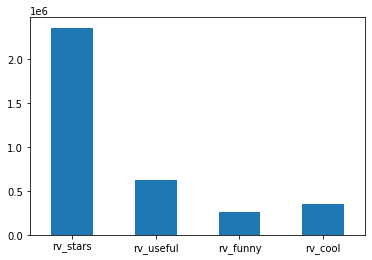

In [16]:
# Numbers of different types of reviews
yelp_coffee[['rv_stars', 'rv_useful', 'rv_funny', 'rv_cool']].sum().plot.bar(rot=0)

Looks like there's more "useful" review than the others.  
Since we got too many reviews and stores in our data, let's filter out with store_review_count.

(1411, 36)


<AxesSubplot:xlabel='store_review_count'>

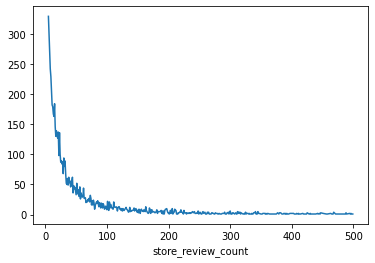

In [50]:
shop_filter = yelp_coffee.drop_duplicates('business_id').groupby('store_review_count')['business_id'].count()
print(yelp_coffee[yelp_coffee['store_review_count']>100].drop_duplicates('business_id').shape)
shop_filter[shop_filter.index<500].plot.line()

Looks like review_count 100 is a good point.  
And after filtering, we have 1411 stores remain.

In [51]:
yelp_coffee_filtered = yelp_coffee[yelp_coffee['store_review_count']>100]

In [52]:
yelp_coffee_filtered.columns

Index(['user_id', 'business_id', 'rv_stars', 'rv_useful', 'rv_funny',
       'rv_cool', 'text', 'date', 'name', 'city', 'state', 'store_stars',
       'store_review_count', 'is_open', 'attributes', 'categories', 'hours',
       'user_review_count', 'yelping_since', 'useful', 'funny', 'cool',
       'elite', 'fans', 'average_stars', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos'],
      dtype='object')

In [61]:
yelp_coffee_filtered[['rv_stars','text']]

,rv_stars,text
0,1,Great coffee and pastries. Baristas are excellent. All the other staff are sooooo lost and vacant.
1,5,Incredible donuts. Sometimes you have to go early to have the full selection but the donuts never disappoint.
2,5,"Dont bother going to voodoo, just come here instead. They have such unique flavors and everything is so fresh. Oh, and try their cold brew too!"
4,4,"It's crazy how establishments on the west coast have so many more yelp reviews than places on the east coast. I find this extremely fascinating and I wish more people would be as passionate as the west coast has proven to me.\n\nIt was recommended that we go here for brunch...needless to say whomever told me this, is a genius.\n\nFresh brunch food, delicious infused vodka's, awesome buttermilk biscuits.\n\nI ordered the ""roll over"" two potato cakes that had a egg scramble with delicious sausage that wasn't gross and covered in grease and then all of this was topped with your choice of a bacon gravy or a mushroom and rosemary gravy. Personally, I chose the mushroom rosemary gravy and I think that it was hands down the best gravy I had ever tried.\n\nI might has well licked the entire plate because it looked like it when I was finished. The flavors were just right and I was shocked at the lack of greasiness that usual breakfast foods come with and their perfectly prepared dishes were done to my liking!\n\nLastly, make sure you order the biscuit too because it's heaven baked in the oven for your enjoyment.\n\nTake care & savor it up!"
5,4,"5 stars for the location, it's absolutely wonderful. I ordered the shamrock bubble tea, which was one of the best I've ever had. I am subtracting a star for service however. It was the barista that was so put out by waiting on us and then the 10-15 minutes it took to make the bubble tea... That's a bit long for a drink."
...,...,...
605295,5,"Ever since I returned from Australia, I wondered why restaurants here didn't go above and beyond on food presentation the way that the Aussies did. Edible Flowers, gorgeous dishes, beautiful bright and colorful layers stacked high, etc. was just not a thing in Portland. There is something about it that makes the dining experience just a bit more pleasant, and as soon as I heard about Proud Mary, I felt those same nostalgic Australian vibes. Turns out, Proud Mary is from Melbourne, and everything made sense.\n\nI got to hear beautiful accents all around me, eat my Vegemite on toast, drink delicious coffee, sit in a gorgeous restaurant, and eat beautiful food. I got to escape for a bit, and I felt like I was back on the other side of the world. \n\nI'm still waiting for the edible floral and fruit stacked pancakes that I have yet to find in America, but I will wait. I know they'll come. As for what I did have, delicious. I am praying for more and more vegan items to show up on the menu, but I like the options we've been given thus far. \n\nGood on ya"
605296,4,"It's a super solid coffee shop. You could tell how good their coffee is just by the amount of people waiting in line at 9 in the morning, and there aren't any other places nearby that are worth stopping by either. The inside is very unique and gives a slightly ""rugged"" vibe (?). I ordered a chai latte, and I really liked it. It's on the milkier side, and even watered down, it's still good. My friend ordered an iced vanilla latte, and it's also on the creamier side. I preferred my chai latte. I love how they're handling COVID (only one customer inside at a time). They also have delicious pastries. I would definitely come back again!"
605297,5,"Chattahoochee Coffee Company you are really amazing, I had an incredible experience here yesterday. Outstanding menu items, welcoming staff, charming mood - what more could you ask for? Each and every single thing that we have purchased was very fresh and yummy. Staff ensured that every thing was fine. The service was good and I would definitely go back to Chattahoochee Coffee Co

In [57]:
yelp_coffee_filtered

,user_id,business_id,rv_stars,rv_useful,rv_funny,rv_cool,text,date,name,city,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JHXQEayrDHOWGexs0dCviA,KXCXaF5qimmtKKqnPc_LQA,1,0,0,0,Great coffee and pastries. Baristas are excell...,2018-03-03 23:45:25,Thierry,Vancouver,...,2,0,0,0,2,11,2,2,0,1
1,LV1ME-ibA2h0IGyFUUWhaQ,H_RM2u1WWGU1HkKZrYq2Ow,5,0,0,0,Incredible donuts. Sometimes you have to go ea...,2017-08-07 19:34:13,Blue Star Donuts,Portland,...,0,0,0,0,0,1,0,0,0,0
2,JuM-lH05m6Ln8OPUTg8p0g,H_RM2u1WWGU1HkKZrYq2Ow,5,0,0,0,"Dont bother going to voodoo, just come here in...",2016-09-18 17:06:01,Blue Star Donuts,Portland,...,0,0,0,0,0,1,0,0,0,0
4,7mWnNVk2n99JxkvV3PW0nA,Un6u2cECyV4nZb_HGZ-uTA,4,1,0,1,It's crazy how establishments on the west coas...,2011-02-13 16:38:09,Tin Shed Garden Cafe,Portland,...,4,1,0,3,12,28,28,28,18,1
5,onoPTc_dcSlQOOk6PUxpaw,g4CP3kgH1jTtMn-joxPT0A,4,0,0,0,"5 stars for the location, it's absolutely wond...",2018-04-27 18:41:52,Tea Chai Te,Portland,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605295,IsIY7fCByHzsotnWxzHdsg,n0ULOj-f6VQwBoS-7tHmUg,5,2,0,1,"Ever since I returned from Australia, I wonder...",2018-09-04 21:42:57,Proud Mary Coffee,Portland,...,2,1,0,0,11,5,16,16,11,5
605296,KXRSfwxC5tV7qwyX333XzA,fSTLgWmOJ3ngs31aPGRpHQ,4,0,0,0,It's a super solid coffee shop. You could tell...,2021-01-10 00:11:03,Flat Track Coffee,Austin,...,0,0,0,0,4,5,1,1,4,0
605297,DpktmsJzeBPo_1kUhefMnA,byuYfWgUbep6tQiH3F5Yjw,5,0,0,0,Chattahoochee Coffee Company you are really am...,2020-12-01 20:59:09,Chattahoochee Coffee Company,Atlanta,...,0,0,0,0,0,0,1,1,0,0
605298,im-MIiI-UFJsdrmIaxer2A,edlA6hSakvNxRZQFbuf-Iw,3,0,0,0,I've always gone to sharetea wherever I go for...,2021-01-25 23:04:35,Sharetea,Beaverton,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Looking people that frequently post about coffee shops on yelp
